# Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score,  precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import warnings
warnings.filterwarnings("ignore")

# Loading the dataset

In [2]:
data = pd.read_csv('dataSet_Badrinath.csv')

# Displaying the data

In [3]:
data

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


# Data Exploration

### Data summary. This will give an idea about missing values, range of each columns

In [4]:
data.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


### Checking the distribution of high, medium and low quality machines in the dataset

In [5]:
data['Type'].value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

### Checking the types of failures and their distributions

In [6]:
data['Failure Type'].value_counts()

Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

### Checking the data types of all the columns. Because, the model might be impacted if the data types are not in the right format

In [7]:
print(data.dtypes)

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object


### Creating a pivot table to see the distribution of failure types

In [8]:
# Create a pivot table
pd.crosstab(index=data['Failure Type'], columns=data['Target'])

Target,0,1
Failure Type,,
Heat Dissipation Failure,0,112
No Failure,9643,9
Overstrain Failure,0,78
Power Failure,0,95
Random Failures,18,0
Tool Wear Failure,0,45


### There are 18 rows labeled as 'Random Failures' even when there is no failure and 9 rows labeled as 'No Failures' when there are failures

### Plotting correlation matrix to see if there is any relation between the variables

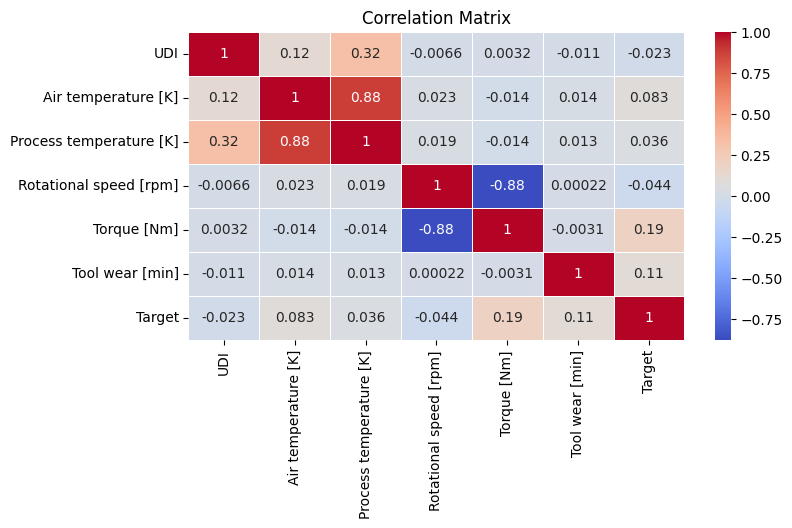

In [9]:
numeric_columns = data.select_dtypes(include=['number']).columns
numeric_data = data[numeric_columns]
correlation_matrix = numeric_data.corr()

# Create a heatmap for visualization
plt.figure(figsize=(8,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [10]:
## 'Rotational Speed' and 'Torque' are highly correlated with each other. We know that Torque and Speed are inversely proportional to each other
## 'Air Temperature' and 'Process Temperature' are highly correlated with each other.

# Data cleaning and treatment

### Perform one-hot encoding on 'Type' column and dropping 'Type' column.

In [11]:
df_encoded = pd.concat([data, pd.get_dummies(data['Type'], prefix='Type').astype(int)], axis=1)
df_encoded = df_encoded.drop(columns=['Type'])
print(df_encoded)

        UDI Product ID  Air temperature [K]  Process temperature [K]  \
0         1     M14860                298.1                    308.6   
1         2     L47181                298.2                    308.7   
2         3     L47182                298.1                    308.5   
3         4     L47183                298.2                    308.6   
4         5     L47184                298.2                    308.7   
...     ...        ...                  ...                      ...   
9995   9996     M24855                298.8                    308.4   
9996   9997     H39410                298.9                    308.4   
9997   9998     M24857                299.0                    308.6   
9998   9999     H39412                299.0                    308.7   
9999  10000     M24859                299.0                    308.7   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target  \
0                       1551         42.8                0       

### Creating power column out of the speed and Torque columns and Temperature ratio column out of the temperature columns

In [12]:
df_encoded['Power'] = (df_encoded['Rotational speed [rpm]'] * (2 * np.pi / 60)) / df_encoded['Torque [Nm]']
df_encoded['Temp_ratio'] = (df_encoded['Process temperature [K]']) / df_encoded['Air temperature [K]']

# Removing 'UDI' and 'Product ID' columns as they are just unique IDs for machines

In [13]:
df_encoded_relevant = df_encoded.drop(columns=['Product ID', 'UDI'])
df_encoded_relevant

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Type_H,Type_L,Type_M,Power,Temp_ratio
0,298.1,308.6,1551,42.8,0,0,No Failure,0,0,1,3.794868,1.035223
1,298.2,308.7,1408,46.3,3,0,No Failure,0,1,0,3.184566,1.035211
2,298.1,308.5,1498,49.4,5,0,No Failure,0,1,0,3.175510,1.034888
3,298.2,308.6,1433,39.5,7,0,No Failure,0,1,0,3.799074,1.034876
4,298.2,308.7,1408,40.0,9,0,No Failure,0,1,0,3.686135,1.035211
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14,0,No Failure,0,0,1,5.693915,1.032129
9996,298.9,308.4,1632,31.8,17,0,No Failure,1,0,0,5.374297,1.031783
9997,299.0,308.6,1645,33.4,22,0,No Failure,0,0,1,5.157605,1.032107
9998,299.0,308.7,1408,48.5,25,0,No Failure,1,0,0,3.040112,1.032441


# Modeling

### Train-Test split

In [14]:
X = df_encoded_relevant.drop(['Failure Type','Target'], axis=1)
y = df_encoded_relevant['Target']

#Replacing non-alpha numeric characters with '_' in column names
X.columns = [re.sub(r"[^a-zA-Z0-9_]+", "_", col) for col in X.columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression model

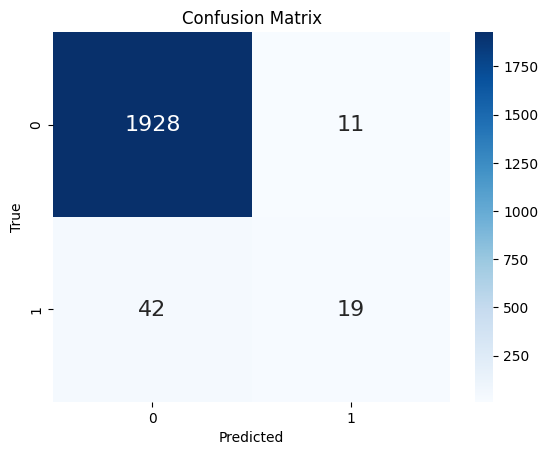

Accuracy: 0.9735
Precision: 0.6333
Recall: 0.3115
F1 Score: 0.4176
AUC: 0.9224


In [15]:
# Initialize the model
lr = LogisticRegression()

# Fit the model to the training data
lr.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_lr = lr.predict(X_test)

# Create a confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Plot the confusion matrix using seaborn's heatmap
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

y_proba_lr = lr.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)

# Print the results
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")
print(f"AUC: {roc_auc_lr:.4f}")

### KNN model

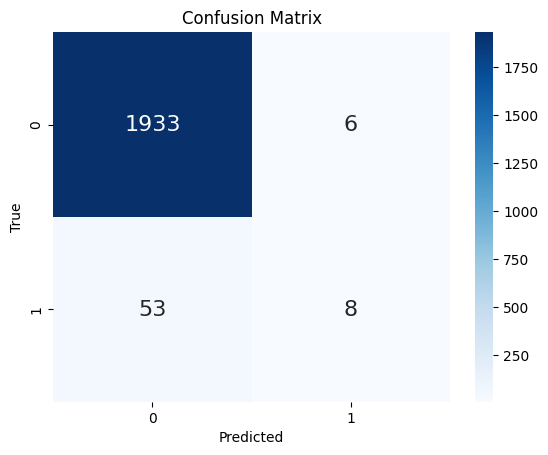

Accuracy: 0.9705
Precision: 0.5714
Recall: 0.1311
F1 Score: 0.2133
AUC: 0.7393


In [16]:
# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model to the training data
knn.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_knn = knn.predict(X_test)

# Create a confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Plot the confusion matrix using seaborn's heatmap
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

y_proba_knn = knn.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, y_proba_knn)

# Print the results
print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")
print(f"AUC: {roc_auc_knn:.4f}")

### XGBoost model

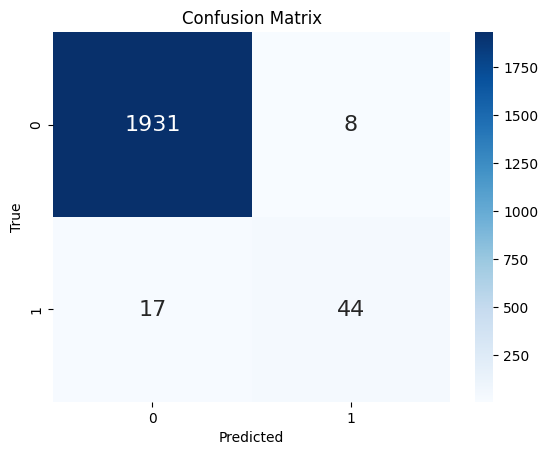

Accuracy: 0.9875
Precision: 0.8462
Recall: 0.7213
F1 Score: 0.7788
AUC: 0.9759


In [17]:
# Initialize the XGBoost classifier
xgb = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

# Fit the model to the training data
xgb.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_xgb = xgb.predict(X_test)

# Create a confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plot the confusion matrix using seaborn's heatmap
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)

# Print the results
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"AUC: {roc_auc_xgb:.4f}")

### Decision Tree model

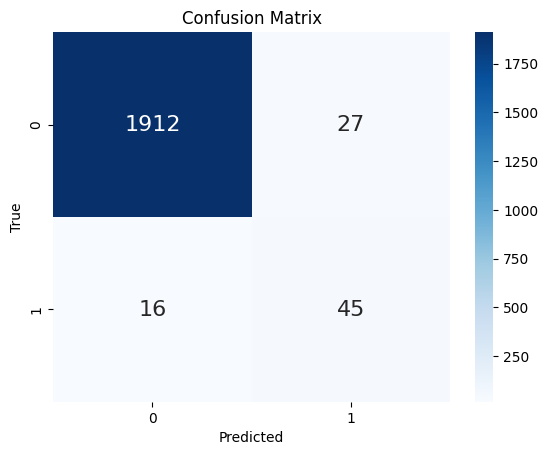

Accuracy: 0.9785
Precision: 0.6250
Recall: 0.7377
F1 Score: 0.6767
AUC: 0.8619


In [18]:
# Initialize the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
dt.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_dt = dt.predict(X_test)

# Create a confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Plot the confusion matrix using seaborn's heatmap
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

y_proba_dt = dt.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)

# Print the results
print(f"Accuracy: {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1 Score: {f1_dt:.4f}")
print(f"AUC: {roc_auc_dt:.4f}")

### Random Forest model

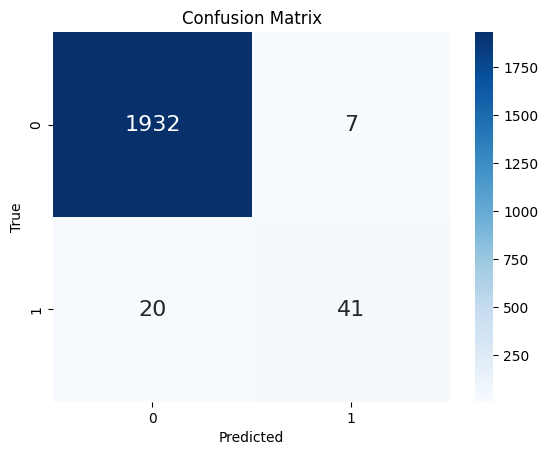

Accuracy: 0.9865
Precision: 0.8542
Recall: 0.6721
F1 Score: 0.7523
AUC: 0.9573


In [19]:
# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_rf = rf.predict(X_test)

# Create a confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix using seaborn's heatmap
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

# Print the results
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"AUC: {roc_auc_rf:.4f}")

### Extra Trees model

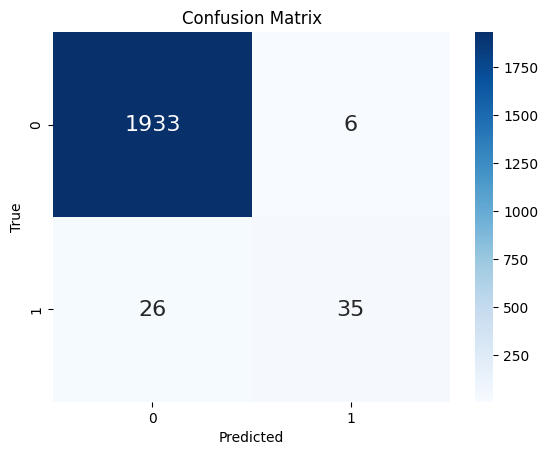

Accuracy: 0.9840
Precision: 0.8537
Recall: 0.5738
F1 Score: 0.6863
AUC: 0.9693


In [20]:
# Initialize the Extra Trees Classifier
extra_trees = ExtraTreesClassifier(random_state=42)

# Fit the model to the training data
extra_trees.fit(X_train, y_train)

# Make predictions on the test data
y_pred_et = extra_trees.predict(X_test)

# Create a confusion matrix
cm_et = confusion_matrix(y_test, y_pred_et)

# Plot the confusion matrix using seaborn's heatmap
sns.heatmap(cm_et, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

y_proba_et = extra_trees.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_et = accuracy_score(y_test, y_pred_et)
precision_et = precision_score(y_test, y_pred_et)
recall_et = recall_score(y_test, y_pred_et)
f1_et = f1_score(y_test, y_pred_et)
roc_auc_et = roc_auc_score(y_test, y_proba_et)

# Print the results
print(f"Accuracy: {accuracy_et:.4f}")
print(f"Precision: {precision_et:.4f}")
print(f"Recall: {recall_et:.4f}")
print(f"F1 Score: {f1_et:.4f}")
print(f"AUC: {roc_auc_et:.4f}")